# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
# Load pickled data
import pickle
import numpy as np
from scipy import ndimage
from sklearn.model_selection import train_test_split
import tensorflow as tf
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
import matplotlib.gridspec as gridspec
import random

# TODO: fill this in based on where you saved the training and testing data
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
train_features, train_labels = train['features'], train['labels']
test_features, test_labels = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(train_features)

# TODO: number of testing examples
n_test = len(test_features)

# TODO: what's the shape of an image?
image_shape = train_features.shape

# TODO: how many classes are in the dataset
n_classes = len(np.unique(test_labels))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (39209, 32, 32, 3)
Number of classes = 43


In [3]:
#Print the 43 class label names
signname_map = np.genfromtxt('signnames.csv', skip_header=1, delimiter=',', usecols=(1,), unpack=True, dtype=str)


# Use the mapping array to print the SignName.
predictions = np.unique(test_labels)
predict_signNames = []
for id in predictions:
    predict_signNames.append(signname_map[int(id)])
print(predict_signNames)

['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vechiles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vechiles', 'Vechiles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vechiles over 3.5 metric tons']


In [4]:
test_features.shape

(12630, 32, 32, 3)

Sample test images: 100%|██████████| 43/43 [00:12<00:00,  3.70labels/s]st images:   2%|▏         | 1/43 [00:00<00:11,  3.67labels/s]


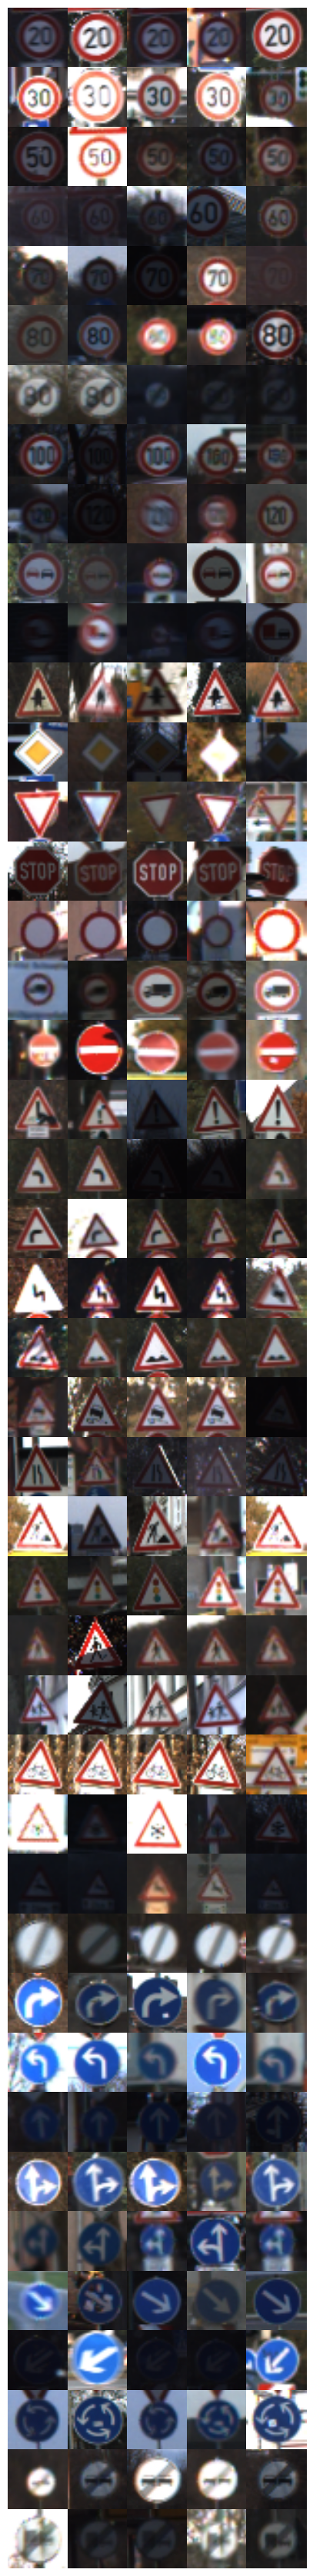

In [5]:
# This print routine was written by my October cohort John Chen and posted on Atlassian
# Using the test data five samples for each of the Forty three classes are plotted
sample_size = 5 #five image per class label
n_labels = 43
count = 0 #book keeping for plots
fig = plt.figure(figsize=(sample_size, n_labels))
grid = gridspec.GridSpec(n_labels, sample_size, wspace=0.0, hspace=0.0)
labelset_pbar = tqdm(range(n_labels), desc='Sample test images', unit='labels')
for i in labelset_pbar:
    ind = test_labels == i
    subset_x =test_features [ind,] #get all images that belong to class i
    for x in range(sample_size):
        img = random.choice(subset_x) #randomly pick on image from class i
        ax = plt.Subplot(fig, grid[count])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img)
        fig.add_subplot(ax)
        count +=1

    # hide the borders
    if i == (n_labels-1):
        all_axes = fig.get_axes()
        for ax in all_axes:
            for sp in ax.spines.values():
                sp.set_visible(False)
plt.show()

In [6]:
# Set flags for feature engineering.  This will prevent you from skipping an important step.
is_features_normal = False
is_labels_encod = False

In [7]:
#Implement Min-Max scaling for image data
def normalize(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    # ToDo: Implement Min-Max scaling for greyscale image data
    a = 0.1
    b = 0.9
    greyscale_min = 0
    greyscale_max = 255
    return a + ( ( (image_data - greyscale_min)*(b - a) )/( greyscale_max - greyscale_min ) )

if not is_features_normal:
    train_features = normalize(train_features)
    test_features = normalize(test_features)
    is_features_normal = True

print('Tests Passed!')



Tests Passed!


In [8]:
from sklearn.preprocessing import OneHotEncoder

def OHE_labels(Y_t,N_classes):
    OHC = OneHotEncoder()
    
    Y_ohc = OHC.fit(np.arange(N_classes).reshape(-1, 1))
    Y_labels = Y_ohc.transform(Y_t.reshape(-1, 1)).toarray()
    
    return Y_labels


train_labels = OHE_labels(train_labels,43)
test_labels = OHE_labels(test_labels,43)
is_labels_encod = True
print('Labels One-Hot Encoded')

Labels One-Hot Encoded


In [9]:
#flatten test and train features
train_features = train_features.reshape(-1, 32*32*3)
test_features = test_features.reshape(-1, 32*32*3)
train_features = train_features.reshape(-1, 32*32*3)

In [10]:
assert is_features_normal, 'You skipped the step to normalize the features'
assert is_labels_encod, 'You skipped the step to One-Hot Encode the labels'

# Get randomized datasets for training and validation
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.10,
    random_state=0)

print('Training features and labels randomized and split.')

Training features and labels randomized and split.


In [11]:
#Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)
train_features = train_features.astype(np.float32)
test_features = test_features.astype(np.float32)
valid_features = valid_features.astype(np.float32)
valid_labels = valid_labels.astype(np.float32)

In [12]:
valid_features.shape

(3921, 3072)

In [13]:
### Data exploration visualization goes here.


In [14]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
features_count = 32*32*3
labels_count = 43

#Set the features and labels tensors
features = tf.placeholder(tf.float32)
labels = tf.placeholder(tf.float32)

# Problem 2 - Set the weights and biases tensors
weights = tf.Variable(tf.truncated_normal((features_count, labels_count)))
biases = tf.Variable(tf.zeros(labels_count))


In [15]:
#Error detection section
#Test Cases
from tensorflow.python.ops.variables import Variable

assert features._op.name.startswith('Placeholder'), 'features must be a placeholder'
assert labels._op.name.startswith('Placeholder'), 'labels must be a placeholder'
assert isinstance(weights, Variable), 'weights must be a TensorFlow variable'
assert isinstance(biases, Variable), 'biases must be a TensorFlow variable'

assert features._shape == None or (\
    features._shape.dims[0].value is None and\
    features._shape.dims[1].value in [None, features_count]), 'The shape of features is incorrect'
assert labels._shape in [None, labels_count], 'The shape of labels is incorrect'
assert weights._variable._shape == (features_count, labels_count), 'The shape of weights is incorrect'
assert biases._variable._shape == (labels_count), 'The shape of biases is incorrect'

assert features._dtype == tf.float32, 'features must be type float32'
assert labels._dtype == tf.float32, 'labels must be type float32'

In [16]:
# Feed dicts for training, validation, and test session#valid_feed_dict = {features: valid_features, labels: valid_labels}

train_feed_dict = {features: train_features, labels: train_labels}
valid_feed_dict = {features: valid_features, labels: valid_labels}

# Linear Function WX + b
logits = tf.matmul(features, weights) + biases

prediction = tf.nn.softmax(logits)

# Cross entropy

cross_entropy = tf.reduce_mean(-tf.reduce_sum(labels * tf.log(tf.clip_by_value(prediction,1e-10,1.0)), 
                                              reduction_indices=[1]))


# Training loss
loss = tf.reduce_mean(cross_entropy)

# Create an operation that initializes all variables
init = tf.initialize_all_variables()

In [17]:
# Test Cases
with tf.Session() as session:
    session.run(init) 
    session.run(loss, feed_dict=train_feed_dict)
    session.run(loss, feed_dict=valid_feed_dict)
    
    biases_data = session.run(biases)

assert not np.count_nonzero(biases_data), 'biases must be zeros'

print('Tests Passed!')

Tests Passed!


In [18]:
# Determine if the predictions are correct
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
# Calculate the accuracy of the predictions
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

print('Accuracy function created.')

Accuracy function created.


Epoch  2/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.3305279314517975 Training accuracy at 0.33784857392311096


Epoch  3/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.6052027344703674 Training accuracy at 0.604709804058075


Epoch  4/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.7278755307197571 Training accuracy at 0.7349523901939392


Epoch  5/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.7541443705558777 Training accuracy at 0.7644525170326233


Epoch  6/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.7760775089263916 Training accuracy at 0.7907220721244812


Epoch  7/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.808212161064148 Training accuracy at 0.8298288583755493


Epoch  8/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.7515940070152283 Training accuracy at 0.7742292284965515


Epoch  9/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.808212161064148 Training accuracy at 0.8334844708442688


Epoch 10/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.8212190866470337 Training accuracy at 0.8445930480957031


Epoch 11/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.8194338083267212 Training accuracy at 0.8436012268066406


Epoch 12/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.8349910974502563 Training accuracy at 0.8588188886642456


Epoch 13/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.8485080599784851 Training accuracy at 0.8746882677078247


Epoch 14/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.8523336052894592 Training accuracy at 0.8794491291046143


Epoch 15/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.8589645624160767 Training accuracy at 0.8871854543685913


Epoch 16/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.8546289205551147 Training accuracy at 0.8829346895217896


Epoch 17/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.854118824005127 Training accuracy at 0.8814327716827393


Epoch 18/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.8579444289207458 Training accuracy at 0.8884606957435608


Epoch 19/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.8454475998878479 Training accuracy at 0.8744615912437439


Epoch 20/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.8755419254302979 Training accuracy at 0.9068521857261658


Epoch 21/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.8816628456115723 Training accuracy at 0.9126331806182861


Epoch 22/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.869931161403656 Training accuracy at 0.9027431607246399


Epoch 23/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.8597296476364136 Training accuracy at 0.8927397131919861


Epoch 24/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.8747768402099609 Training accuracy at 0.9105644822120667


Epoch 25/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.8811527490615845 Training accuracy at 0.9150986075401306


Epoch 26/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.8895689845085144 Training accuracy at 0.9244219064712524


Epoch 27/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.8875287175178528 Training accuracy at 0.9230332970619202


Epoch 28/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.8916093111038208 Training accuracy at 0.9254987239837646


Epoch 29/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.8895689845085144 Training accuracy at 0.9256404638290405


Epoch 30/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.8933945298194885 Training accuracy at 0.9285309314727783


Epoch 31/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.8839581608772278 Training accuracy at 0.9191793203353882


Epoch 32/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.8824279308319092 Training accuracy at 0.9180458188056946


Epoch 33/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.8918642997741699 Training accuracy at 0.9280492067337036


Epoch 34/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.8880387544631958 Training accuracy at 0.9262638688087463


Epoch 35/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.8834481239318848 Training accuracy at 0.9160054326057434


Epoch 36/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.8898240327835083 Training accuracy at 0.92850261926651


Epoch 37/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.8916093111038208 Training accuracy at 0.9294377565383911


Epoch 38/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.8926294445991516 Training accuracy at 0.9276524782180786


Epoch 39/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.8987503051757812 Training accuracy at 0.933036744594574


Epoch 40/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.8959448933601379 Training accuracy at 0.9317898154258728


Epoch 41/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.8979852199554443 Training accuracy at 0.9351620674133301


Epoch 42/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9005355834960938 Training accuracy at 0.9370607733726501


Epoch 43/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9048712253570557 Training accuracy at 0.9375991821289062


Epoch 44/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9020658135414124 Training accuracy at 0.9365223050117493


Epoch 45/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.899260401725769 Training accuracy at 0.9352471232414246


Epoch 46/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9038510322570801 Training accuracy at 0.9386193752288818


Epoch 47/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.8979852199554443 Training accuracy at 0.9328100085258484


Epoch 48/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.903596043586731 Training accuracy at 0.9402913451194763


Epoch 49/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.903596043586731 Training accuracy at 0.9396678805351257


Epoch 50/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9002805352210999 Training accuracy at 0.9390444159507751


Epoch 51/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9005355834960938 Training accuracy at 0.9379959106445312


Epoch 52/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.900025486946106 Training accuracy at 0.9376558661460876


Epoch 53/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9010456800460815 Training accuracy at 0.9375991821289062


Epoch 54/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.8982402682304382 Training accuracy at 0.9382226467132568


Epoch 55/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.904106080532074 Training accuracy at 0.9418782591819763


Epoch 56/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9010456800460815 Training accuracy at 0.9403479695320129


Epoch 57/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9018107652664185 Training accuracy at 0.9398379325866699


Epoch 58/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9023208618164062 Training accuracy at 0.9410281181335449


Epoch 59/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9023208618164062 Training accuracy at 0.9401212930679321


Epoch 60/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9015557169914246 Training accuracy at 0.9379959106445312


Epoch 61/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.8995154500007629 Training accuracy at 0.9382226467132568


Epoch 62/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9038510322570801 Training accuracy at 0.941849946975708


Epoch 63/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9018107652664185 Training accuracy at 0.939696192741394


Epoch 64/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9028308987617493 Training accuracy at 0.9419916272163391


Epoch 65/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.903596043586731 Training accuracy at 0.941963255405426


Epoch 66/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9051262140274048 Training accuracy at 0.9435502290725708


Epoch 67/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9071665406227112 Training accuracy at 0.9447970986366272


Epoch 68/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9043611288070679 Training accuracy at 0.9408013820648193


Epoch 69/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9069114923477173 Training accuracy at 0.9461573362350464


Epoch 70/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9028308987617493 Training accuracy at 0.9406597018241882


Epoch 71/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.903596043586731 Training accuracy at 0.9429834485054016


Epoch 72/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.908186674118042 Training accuracy at 0.9449954628944397


Epoch 73/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9061464071273804 Training accuracy at 0.9438619613647461


Epoch 74/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9023208618164062 Training accuracy at 0.9405747056007385


Epoch 75/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.904106080532074 Training accuracy at 0.9432668089866638


Epoch 76/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9066564440727234 Training accuracy at 0.9454488754272461


Epoch 77/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9066564440727234 Training accuracy at 0.9461573362350464


Epoch 78/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9074215888977051 Training accuracy at 0.9459022879600525


Epoch 79/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9064014554023743 Training accuracy at 0.9463273882865906


Epoch 80/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9051262140274048 Training accuracy at 0.9445987343788147


Epoch 81/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9048712253570557 Training accuracy at 0.9450521469116211


Epoch 82/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9053812623023987 Training accuracy at 0.945023775100708


Epoch 83/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9030859470367432 Training accuracy at 0.9432101845741272


Epoch 84/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9071665406227112 Training accuracy at 0.9465257525444031


Epoch 85/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9002805352210999 Training accuracy at 0.9414248466491699


Epoch 86/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9028308987617493 Training accuracy at 0.9443719983100891


Epoch 87/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.903596043586731 Training accuracy at 0.9441453218460083


Epoch 88/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9056363105773926 Training accuracy at 0.9478576183319092


Epoch 89/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9061464071273804 Training accuracy at 0.9490761756896973


Epoch 90/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9051262140274048 Training accuracy at 0.9458172917366028


Epoch 91/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9053812623023987 Training accuracy at 0.9469224810600281


Epoch 92/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9056363105773926 Training accuracy at 0.9459022879600525


Epoch 93/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9053812623023987 Training accuracy at 0.9476025700569153


Epoch 94/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9086967706680298 Training accuracy at 0.9494729042053223


Epoch 95/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9043611288070679 Training accuracy at 0.947177529335022


Epoch 96/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9056363105773926 Training accuracy at 0.9480276703834534


Epoch 97/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9061464071273804 Training accuracy at 0.9484810829162598


Epoch 98/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9043611288070679 Training accuracy at 0.9462140202522278


Epoch 99/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9051262140274048 Training accuracy at 0.9453921914100647


Epoch 100/100:   0%|          | 0/1765 [00:00<?, ?batches/s]

Validation accuracy at 0.9056363105773926 Training accuracy at 0.946894109249115


Epoch 100/100: 100%|██████████| 1765/1765 [00:04<00:00, 388.09batches/s]h 100/100:   2%|▏         | 43/1765 [00:00<07:23,  3.89batches/s]


Validation accuracy at 0.9051262140274048 Training accuracy at 0.9460723400115967


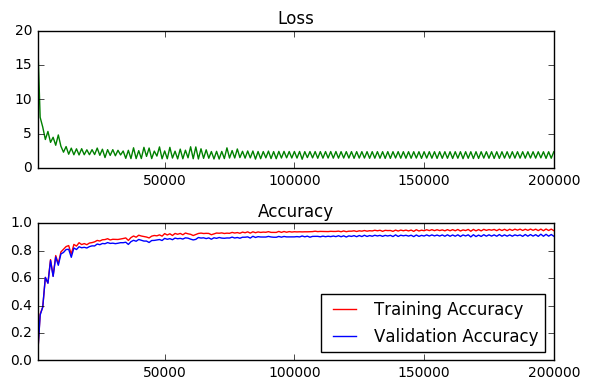

In [19]:
epochs = 100
batch_size = 20
learning_rate = .24
global batch_start
# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)    

# The accuracy measured against the validation set
validation_accuracy = 0.0

# Measurements use for graphing loss and accuracy
log_batch_step = 1000
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

with tf.Session() as session:
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer and get loss
            _, l = session.run(
                [optimizer, loss],
                feed_dict={features: batch_features, labels: batch_labels})

            # Log every 50 batches
            if not batch_i % log_batch_step:
                # Calculate Training and Validation accuracy
                training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
                validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                loss_batch.append(l)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)
        print('Validation accuracy at {}'.format(validation_accuracy),'Training accuracy at {}'.format(training_accuracy) )
        # Check accuracy against Validation data
        validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

The main three techniques required to setup up training and testing of the German Traffic Signs data are normalizing all of the data, hot-one encoding all of the labels and flattening all of the features.  Since I was restricted to Docker Toolbox that does not have cv2, skimage tools, I choose to flatten the features.  There is inherit loss of accuracy due to all three of these preprocess steps.  I also defined tensorflow place holders. 
The names of the signs were extracted from the provided signnames.csv file.  The 43 traffic signs in the German Traffic Sign in test.p data file are:

    	
    
Label Number      Name of the Traffic Sign   

1	               Speed limit (20km/h)
2         	       Speed limit (30km/h)
3	               Speed limit (50km/h)
4	               Speed limit (60km/h)
5	               Speed limit (70km/h)
6	               Speed limit (80km/h)
7	               End of speed limit (80km/h)
8	               Speed limit (100km/h)
9	               Speed limit (120km/h)
10	               No passing
11	               No passing for vehicles over 3.5 metric tons
12	               Right-of-way at the next intersection
13	               Priority road
14	               Yield
15	               Stop
16	               No vehicles
17	               Vehicles over 3.5 metric tons prohibited
18	               No entry
19	               General caution
20	               Dangerous curve to the left
21	               Dangerous curve to the right
22	               Double curve
23	               Bumpy road
24	               Slippery road
25	               Road narrows on the right
26	               Road work
27	               Traffic signals
28	               Pedestrians
29	               Children crossing
30	               Bicycles crossing
31	               Beware of ice/snow
32	               Wild animals crossing
33	               End of all speed and passing limits
34	               Turn right ahead
35	               Turn left ahead
36	               Ahead only
37	               Go straight or right
38	               Go straight or left
39	               Keep right
40	               Keep left
41	               Roundabout mandatory
42	               End of no passing
43	               End of no passing by vehicles over 3.5 metric tons



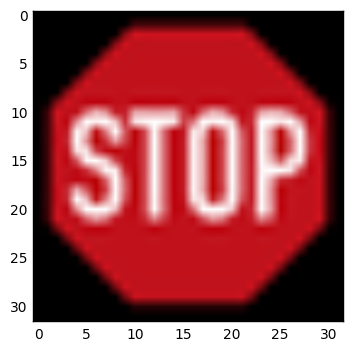

In [20]:
#Pictures 
img=Image.open('stop.png')
img_rgb = img.convert('RGB')
img_rgb.thumbnail((32,32), Image.ANTIALIAS)
X_tr = np.reshape(img_rgb, (1, 32, 32, 3))
plt.imshow(img_rgb)


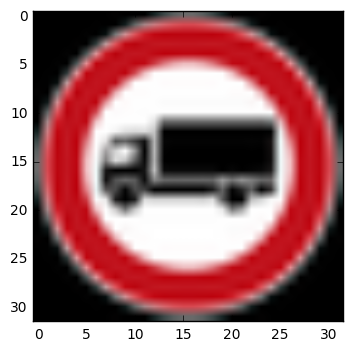

In [22]:
img=Image.open('trump.png')
img_rgb = img.convert('RGB')
img_rgb.thumbnail((32,32), Image.ANTIALIAS)
X_tr2 = np.reshape(img_rgb, (1, 32, 32, 3))
plt.imshow(img_rgb)

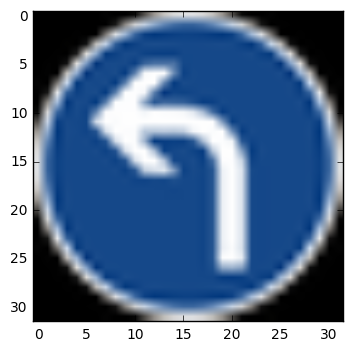

In [23]:
img=Image.open('turnleft.png')
img_rgb = img.convert('RGB')
img_rgb.thumbnail((32,32), Image.ANTIALIAS)
X_tr3 = np.reshape(img_rgb, (1, 32, 32, 3))
plt.imshow(img_rgb)


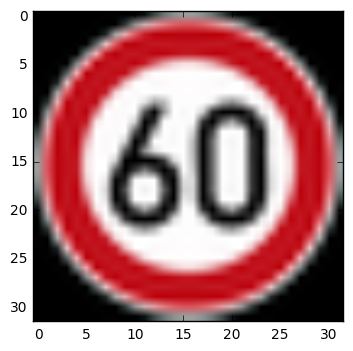

In [24]:
img=Image.open('60kmph.png')
img_rgb = img.convert('RGB')
img_rgb.thumbnail((32,32), Image.ANTIALIAS)
X_tr4 = np.reshape(img_rgb, (1, 32, 32, 3))
plt.imshow(img_rgb)

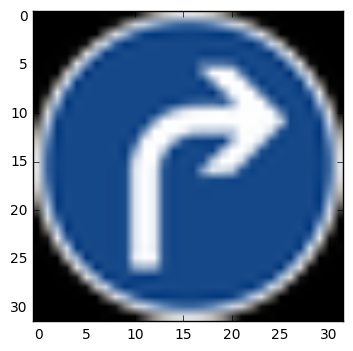

In [25]:
img=Image.open('turnright.png')
img_rgb = img.convert('RGB')
img_rgb.thumbnail((32,32), Image.ANTIALIAS)
X_tr5 = np.reshape(img_rgb, (1, 32, 32, 3))
plt.imshow(img_rgb)

In [26]:
newdata = X_tr
newdata = np.vstack([newdata, X_tr2])
newdata = np.vstack([newdata, X_tr3])
newdata = np.vstack([newdata, X_tr4])
newdata = np.vstack([newdata, X_tr5])
newdata = newdata.reshape(-1, 32*32*3)

In [27]:
a = np.zeros((1,43))

In [28]:
# now add the one in 15th position for the stop sign
a[0,14] = 1

In [29]:
# now add the one in 17th position for the truck sign
b = np.zeros((1,43))
b[0,16]=1

In [30]:
# now add the one in 35th position for the left turn sign
c = np.zeros((1,43))
c[0,34]=1

In [31]:
# now add the one in 4th position for the 60kpm sign
d = np.zeros((1,43))
d[0,3] = 1

In [32]:
# now add the one in 34th position for the right sign
e = np.zeros((1,43))
e[0,33]=1

In [33]:
#make newdata labels
newlabels = a
newlabels = np.vstack([newlabels, b])
newlabels = np.vstack([newlabels, c])
newlabels = np.vstack([newlabels, d])
newlabels = np.vstack([newlabels, e])

In [34]:
# Add an op to initialize the variables.
#prediction = tf.nn.softmax(logits)
init_op = tf.initialize_all_variables()
topFive=tf.nn.top_k(prediction, k=5, sorted=True, name=None)
top_k_feed_dict = {features: newdata}
# Run the tf.nn.top_k operation in the session

with tf.Session() as session:
    # Run the init operation.
    session.run(init_op)
    top_k_pred = (session.run(topFive, feed_dict = top_k_feed_dict))
    #values = np.array([top_k_pred.values])
    #indices = np.array([top_k_pred.indices])
    top5_pred_sftmax = top_k_pred[0]
    top5_pred_labels = top_k_pred[1]

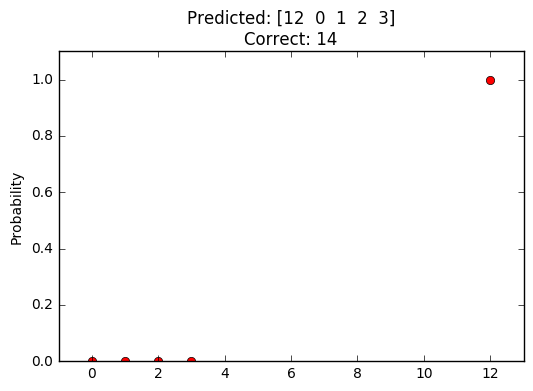

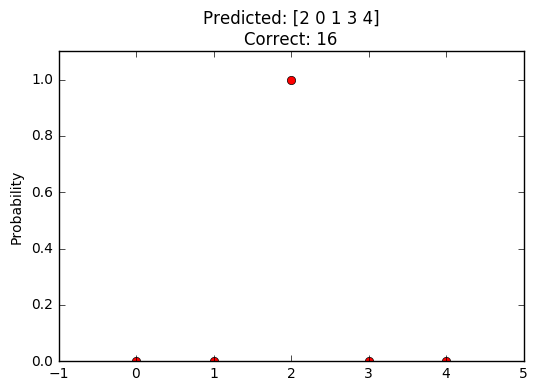

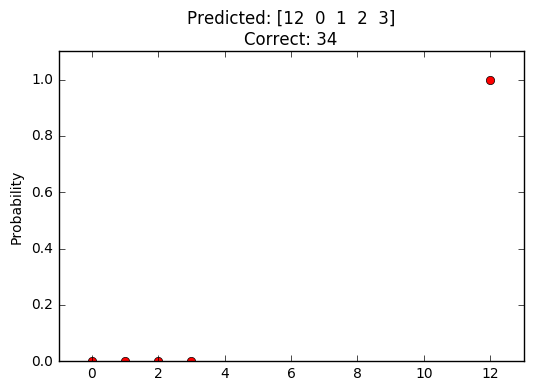

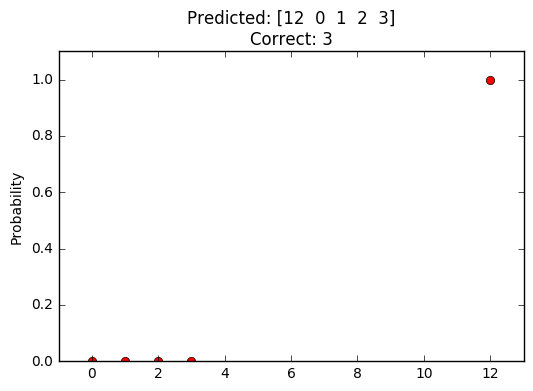

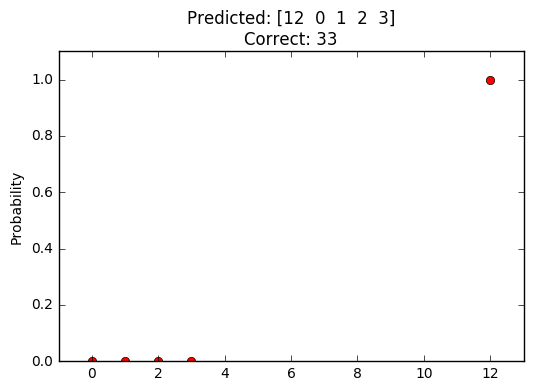

In [35]:
def plot_top_k_probabilities(pred_cls, pred_prob, title):
    plt.plot(list(pred_cls), list(pred_prob), 'ro')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1-1,x2+1,y1,y2+0.1))

    plt.ylabel('Probability')
    plt.title(title)
 
    plt.show()

for i in range(len(top5_pred_sftmax)):
    #predicted_class = top5_pred_labels[i][np.argmax(top5_pred_sftmax [i])]
    predicted_class = top5_pred_labels[i]
    correct_class = np.argmax(newlabels[i])

    plot_title = 'Predicted: {}\nCorrect: {}'.format(predicted_class, correct_class) 
    
    plot_top_k_probabilities(top5_pred_labels[i], top5_pred_sftmax[i], plot_title)
    print('')
    print('')

The pickled data dictionary was used to read in the German traffic sign dataset the following attributes.
1.  Image pixel values and color, (32 pixels , 32 pixels, 3 channels)
2.  Labels - the label of the traffic sign
3.  Features, the image pixel values.
4.  Size feature was used to plot the images and sampling areas.
The training and test data is initially extracted from the German traffic signs dataset.  Validation data is generated by duplicating 5% of the training data.


The final architecture of the linear model similar to the TensorFlow lab begins with the Linear Function or logits ,WX + b.  The softmax is estimated the prediction of the traffic sign.  Cross Entropy and loss are calculated.  Loss is the the significant parameter as this calculated value is used to predict the accuracy

For the linear neural model, experimented and decided upon:
    
epochs = 100
batch_size = 20
learning_rate = .24

I choose five German traffic signs from the web.  All five are plotted in the linear neural notebook.  It appears one of my images was not detect.  Perhaps the red stop sign and the red do not enter sign are too similar.  

Comparison between the performance of the captured images with that of the test set.

In comparison of the 5 captured images I had a 0% accuracy versus a training accuracy at 95%.

The difficulty in my five images are they fill the 32X32 pixel more than the training images.  I took pictures off of the web that are not similar to real German traffic sign pictures uses as training data.
